## A simple multinomial logit model using the Swissmetro dataset

In [1]:
import sys
sys.path.append('..')

In [2]:
# import packages
import pandas as pd

from pycmtensor import train
from pycmtensor import Dataset
from pycmtensor.expressions import Beta
import pycmtensor.optimizers as optim
import pycmtensor.scheduler as sched
from pycmtensor.models import MNL

import pycmtensor
pycmtensor.about()

PyCMTensor  : 1.13.0
Aesara      : 2.9.3


In [3]:
# read the data and load it into a dataset
df = pd.read_csv('http://transp-or.epfl.ch/data/swissmetro.dat', sep='\t')

# remove unknown choices
df = df.loc[df["CHOICE"] > 0]

# Load the DataFrame into a Dataset object
ds = Dataset(df, choice="CHOICE")
ds.scale_variable("TRAIN_TT", 100)
ds.scale_variable("SM_TT", 100)
ds.scale_variable("CAR_TT", 100)
ds.scale_variable("TRAIN_CO", 100)
ds.scale_variable("SM_CO", 100)
ds.scale_variable("CAR_CO", 100)
ds.split(frac=0.80)

# Define the alternative specific constants (ASCs) for each mode of transport
ASC_TRAIN = Beta("ASC_TRAIN", 0., None, None, 0)
ASC_SM = Beta("ASC_SM", 0., None, None, 0)
ASC_CAR = Beta("ASC_CAR", 0., None, None, 1)

# Define the coefficients for the variables
B_COST = Beta("B_COST", 0., None, None, 0)
B_TIME_TRAIN = Beta("B_TIME_TRAIN", 0., None, None, 0)
B_TIME_SM = Beta("B_TIME_SM", 0., None, None, 0)
B_TIME_CAR = Beta("B_TIME_CAR", 0., None, None, 0)
B_SEAT = Beta("B_SEAT", 0., None, None, 0)

# Define the utility functions for each mode of transport
V_TRAIN = (
	ASC_TRAIN 
	+ B_TIME_TRAIN * ds["TRAIN_TT"] 
	+ B_COST * ds["TRAIN_CO"]
)
V_SM = (
	ASC_SM 
	+ B_TIME_SM * ds["SM_TT"] 
	+ B_COST * ds["SM_CO"] 
	+ B_SEAT * ds["SM_SEATS"]
)
V_CAR = (
	ASC_CAR 
	+ B_TIME_CAR * ds["CAR_TT"] 
	+ B_COST * ds["CAR_CO"]
)

# Define the model
U = [V_TRAIN, V_SM, V_CAR]
AV = [ds["TRAIN_AV"], ds["SM_AV"], ds["CAR_AV"]]
model = MNL(ds, locals(), U, AV)

13:56:50 [INFO] CHOICE: {0: 1423, 1: 6216, 2: 3080}
13:56:50 [INFO] seed: 100 n_train_samples:8575 n_valid_samples:2144
13:56:53 [INFO] inputs in MNL: [TRAIN_AV, CAR_AV, SM_AV, TRAIN_TT, TRAIN_CO, SM_TT, SM_CO, SM_SEATS, CAR_TT, CAR_CO]
13:56:53 [INFO] Build time = 00:00:03


Estimate the model

In [4]:
# Train model
model.reset_values()
train(model, ds, optimizer=optim.Adam, lr_scheduler=sched.ConstantLR, batch_size=0, max_epochs=2000, base_learning_rate=0.01, convergence_threshold=1e-3, acceptance_method=0)

13:56:57 [INFO] Start (n=8575, epoch=0, NLL=-8869.17, error=86.29%)
13:56:57 [INFO] Train 0/2K (epoch=0, LL=-8735.75, error=42.77%, gnorm=2.646e-02)
13:56:59 [INFO] Train 126/2K (epoch=126, LL=-7269.83, error=42.72%, gnorm=7.075e-03)
13:57:00 [INFO] Train 193/2K (epoch=193, LL=-7171.72, error=40.81%, gnorm=5.508e-03)
13:57:01 [INFO] Train 266/2K (epoch=266, LL=-7115.63, error=38.67%, gnorm=4.116e-03)
13:57:02 [INFO] Train 364/2K (epoch=364, LL=-7079.41, error=37.78%, gnorm=2.747e-03)
13:57:03 [INFO] Train 436/2K (epoch=436, LL=-7065.88, error=37.27%, gnorm=2.115e-03)
13:57:06 [INFO] Train 600/2K (epoch=600, LL=-7050.68, error=37.17%, gnorm=1.407e-03)
13:57:08 [INFO] Train 743/2K (epoch=743, LL=-7044.91, error=37.17%, gnorm=1.055e-03)
13:57:08 [INFO] Train 768/2K (epoch=768, LL=-7044.28, error=37.08%, gnorm=9.986e-04)
13:57:08 [INFO] Model converged (t=11.584)
13:57:08 [INFO] Best results obtained at epoch 474: LL=-7060.98, error=37.08%, gnorm=1.88409e-03


Display model results:

In [5]:
display(model.results.beta_statistics())
display(model.results.model_statistics())
display(model.results.benchmark())

,value,std err,t-test,p-value,rob. std err,rob. t-test,rob. p-value
ASC_CAR,0.0,-,-,-,-,-,-
ASC_SM,0.041,0.043,0.953,0.341,0.047,0.858,0.391
ASC_TRAIN,-0.416,0.057,-7.24,0.0,0.059,-7.096,0.0
B_COST,0.015,0.002,6.05,0.0,0.002,7.343,0.0
B_SEAT,-0.012,0.076,-0.162,0.871,0.085,-0.146,0.884
B_TIME_CAR,-0.978,0.05,-19.481,0.0,0.061,-16.026,0.0
B_TIME_SM,-1.127,0.065,-17.301,0.0,0.103,-10.913,0.0
B_TIME_TRAIN,-1.271,0.062,-20.461,0.0,0.071,-17.936,0.0


,value
Number of training samples used,8575
Number of validation samples used,2144
Number of estimated parameters in the model,8
Null log likelihood,-8869.17
Init. log likelihood,-8869.17
Final log likelihood,-7060.98
Validation Accuracy,62.92%
Training Accuracy,62.65%
Likelihood ratio test,3616.37
Rho square,0.204


,value
Platform,Windows 10.0.22631
Processor,Intel64
RAM,15.34 GB
Python version,3.11.9
PyCMTensor version,1.13.0
Seed,100
Model build time,00:00:03
Model train time,00:00:12
epochs per sec,66.38 epoch/s


Display model correlation matrices

In [6]:
display(model.results.model_correlation_matrix())
# display(model.results.model_robust_correlation_matrix())

,ASC_TRAIN,ASC_SM,ASC_CAR,B_COST,B_TIME_TRAIN,B_TIME_SM,B_TIME_CAR,B_SEAT
ASC_TRAIN,1.000,-0.552,-0.690,-0.051,-0.777,-0.005,0.125,0.183
ASC_SM,-0.552,1.000,-0.223,-0.197,0.513,-0.275,0.392,-0.287
ASC_CAR,-0.690,-0.223,1.000,0.231,0.463,0.245,-0.486,0.035
B_COST,-0.051,-0.197,0.231,1.000,0.009,0.062,-0.132,-0.141
B_TIME_TRAIN,-0.777,0.513,0.463,0.009,1.000,0.447,0.365,-0.105
B_TIME_SM,-0.005,-0.275,0.245,0.062,0.447,1.000,0.517,0.052
B_TIME_CAR,0.125,0.392,-0.486,-0.132,0.365,0.517,1.000,-0.076
B_SEAT,0.183,-0.287,0.035,-0.141,-0.105,0.052,-0.076,1.000


Plot model Loglikelihood, training and validation error

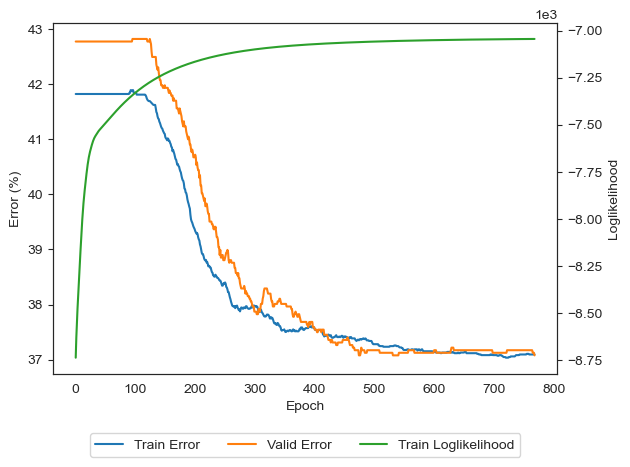

,train_ll,train_error,valid_error,learning_rate
0,-8735.749502,0.418192,0.427705,0.01
1,-8629.937944,0.418192,0.427705,0.01
2,-8546.000971,0.418192,0.427705,0.01
3,-8476.151781,0.418192,0.427705,0.01
4,-8413.023065,0.418192,0.427705,0.01
...,...,...,...,...
764,-7044.379033,0.370962,0.371735,0.01
765,-7044.355167,0.370962,0.371269,0.01
766,-7044.331434,0.370962,0.371269,0.01
767,-7044.307834,0.370962,0.371269,0.01


In [7]:
model.results.show_training_plot()

Model validation prediction

In [8]:
# predict CHOICE on the validation set and display the results.
# First three columns are the probabilities, the fourth column 
# is the predicted choice, fifth column is the actual choice.
pd.DataFrame(model.predict(ds))

,0,1,2,pred_CHOICE,true_CHOICE
0,0.094361,0.684689,0.220950,1,1
1,0.120687,0.436072,0.443241,2,2
2,0.132569,0.625338,0.242093,1,1
3,0.118674,0.598185,0.283141,1,1
4,0.163649,0.836351,0.000000,1,0
...,...,...,...,...,...
2139,0.116049,0.883951,0.000000,1,0
2140,0.134799,0.448723,0.416478,1,1
2141,0.052740,0.741784,0.205476,1,1
2142,0.105443,0.509309,0.385249,1,1


Compute elasticities of SM_CO with respect to CHOICE:SM

In [9]:
sm_co_wrt_sm = model.elasticities(ds, 1)["SM_CO"]
print(sm_co_wrt_sm.mean())

0.030671091474900408


Plot the elasticities

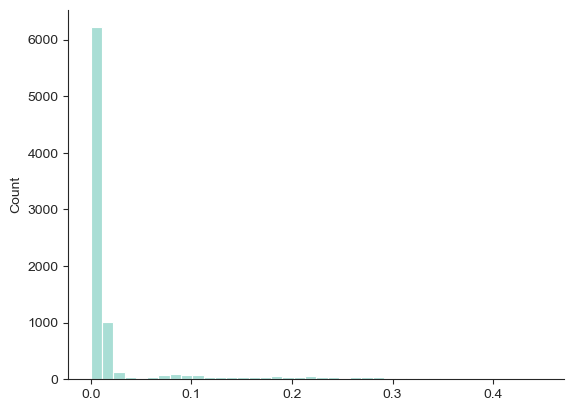

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

fig, ax = plt.subplots()
sns.histplot(sm_co_wrt_sm, kde=False, ax=ax, bins=40)

sns.despine()
plt.show()